
# TFM - Modelos de Propensión para Campañas Comerciales

**Autor:** Grupo 4

#### En este primer Notebook haremos una limpieza del dataset aplicando buenas prácticas y posteriomente haremos una segmentación de los clientes aplicando reglas manuales
---

## 1. Carga de librerías


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")




---

## 2. Carga del dataset y aplicar buenas prácticas


In [21]:
# 1. Cargar y preprocesar los datos
df = pd.read_csv("./Data/customer_shopping_data_v5.csv", delimiter=';')

---

#### 2.1 Detección de Nulos y Duplicados

In [22]:
#Una vez cargado el dataset, lo primero vamos a ver si hay valores nulos y si existen filas duplicadas
print(df.isnull().sum())

print("-------------")
print("Número de filas duplicadas: ", df.duplicated().sum())

Factura             0
ID_Cliente          0
Categoría           0
Cantidad            0
Importe             0
Método de Pago      0
Fecha_Factura       0
Centro_Comercial    0
Canal               0
Género              0
Edad                0
Zona                0
dtype: int64
-------------
Número de filas duplicadas:  0


In [23]:
df.head()

,Factura,ID_Cliente,Categoría,Cantidad,Importe,Método de Pago,Fecha_Factura,Centro_Comercial,Canal,Género,Edad,Zona
0,I000001,C241288,Libros,5,19.31,Otras Tarjetas,05/08/2022,Castellana,Tienda física,Femenino,28,Centro
1,I000002,C111565,Supermercado,3,76.05,Tarjeta ECI,12/12/2021,Marbella,Tienda física,Masculino,21,Sur
2,I000003,C266599,Juguetería,1,108.73,Efectivo,09/11/2021,Plaza Catalunya,Tienda física,Masculino,20,Norte
3,I000004,C988172,Supermercado,5,52.00,Otras Tarjetas,16/05/2021,Goya,Tienda física,Femenino,66,Centro
4,I000005,C189076,Moda,4,95.69,Efectivo,24/10/2021,Castellana,Tienda física,Femenino,53,Centro


#### Parece que no existen ni valores nulos ni filas duplicadas en nuestro dataset, por tanto, para este caso no será necesario realizar nada más

---

#### 2.2 Detección y análisis de Outliers

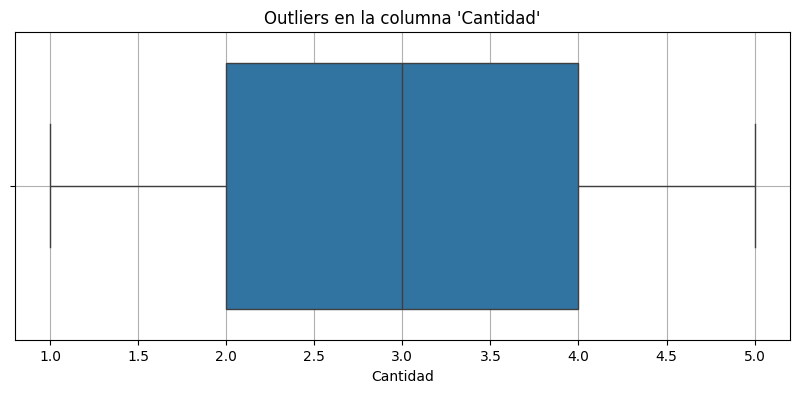

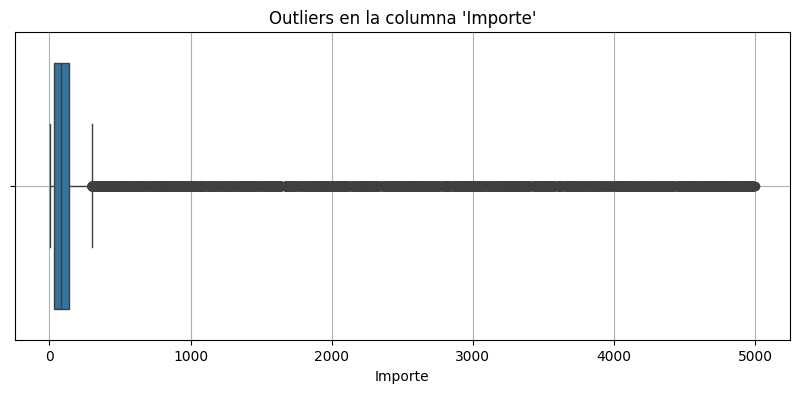

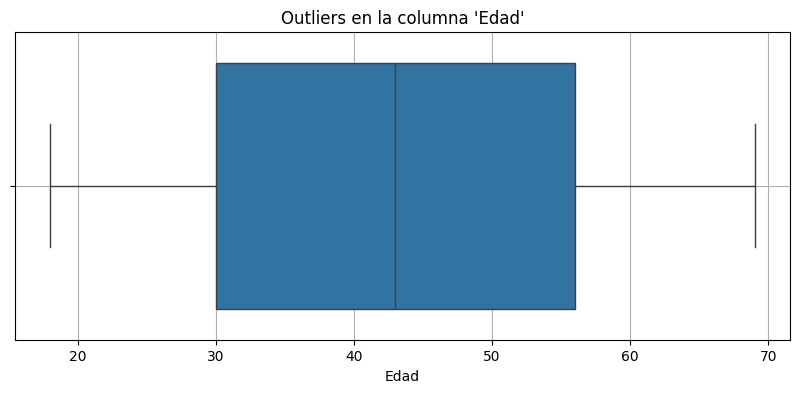

In [24]:
#Visualizamos los outliers para cada columna numérica

for columna in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[columna])
    plt.title(f"Outliers en la columna '{columna}'")
    plt.grid(True)
    plt.show()


In [25]:
#Vamos a crear una funcion que nos diga exactamente cuales son los outliers de una columna
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers

##### Como vemos parece que sólo aparecen outliers en Importe por tanto:
- Vamos a ver cuales son los registros outliers de Importe, ya que viendo las gráficas es en la única columna donde existen outilers, osea valores que se alejan de los valores "normales"
que serían los datos que están entre el Q1 y el Q3

In [26]:

outliers_importe = detectar_outliers(df, "Importe")

# Mostrar los outliers
print(outliers_importe)

        Factura ID_Cliente     Categoría  Cantidad  Importe  Método de Pago  \
6       I000007    C151197   Electrónica         1  2556.45        Efectivo   
8       I000009    C159642  Supermercado         3   309.94  Otras Tarjetas   
61      I000062    C716161   Electrónica         1   321.07     Tarjeta ECI   
110     I000111    C276043  Supermercado         4   333.46        Efectivo   
150     I000151    C816586  Supermercado         4   403.98        Efectivo   
...         ...        ...           ...       ...      ...             ...   
499667  I499668    C998536  Supermercado         1   500.00  Otras Tarjetas   
499764  I499765    C999023  Supermercado         1   500.00        Efectivo   
499782  I499783    C999154  Supermercado         1   403.84  Otras Tarjetas   
499810  I499811    C999318  Supermercado         4   411.33        Efectivo   
499923  I499924    C999853   Electrónica         1   381.40        Efectivo   

       Fecha_Factura Centro_Comercial          Cana

##### Aunque tengamos outliers en el importe, los vamos a conservar ya que el que existan clientes con un importe tan alto es bueno para nuestro propósito que es segmentar a los clientes por sus gastos y frecuencia de compra, para después aplicarlo a campañas comerciales.


---

## 3. Preprocesamiento de las variables

In [27]:
#Asegurar formatos, sobretodo para el campo fecha, vamos a asegurarnos que tiene el formato requerido
df['Fecha_Factura'] = pd.to_datetime(df['Fecha_Factura'], format="%d/%m/%Y")
df['Factura'] = df['Factura'].astype(str)
 

#### Para poder aplicar las reglas de segmentación a los distintos clientes, es necesario realizar los siguientes pasos para así agrupar a los clientes, debido a que en nuestro dataset tenemos varios registros por cliente:
- Crearemos una columna año, como en nuestros datos tenemos registros de varios, pues obtendremos los mismos a partir de la fecha factura para posteriormente agrupar los datos por año


In [28]:
#Crear columna año
df['Año'] = df['Fecha_Factura'].dt.year

#### Agrupación cliente. En este paso realizaremos lo siguiente:
- Obtener la ultima fecha de factura
- Agrupar al cliente, realizando los siguiente cáculos:
    - En importe: Obtenemos el importe total y el ticket medio
    - En factura: Realizamos un count de las facturas del cliente y con ese valor crearemos una columna llamada frecuencia
    - En fecha_factura: Obtendremos el número de días que han pasado desde la última factura y obtendremos el año de la misma
    - En categoría: Obtenemos la categoría top (calculando la moda), la menos frecuente para el cliente (con una función que cuenta que categorías usa menos el cliente) y el número de categorías distintas para cada cliente
    - En canal: Obtenemos el canal que más usa el cliente, para ello hemos obtenido la moda de los datos
    - En edad: Nos quedamos con el primero
    - En método de pago: Obtenemos el método de pago más usado por el cliente, para ello calculamos la moda
    - En género: Nos quedamos con el primero

In [29]:
#Obtenemos la última fecha para posteriormente calcular el numero de dias desde la ultima factura
today = df['Fecha_Factura'].max()

def menos_frecuente(x):
    return x.value_counts().idxmin()


cliente_df = df.groupby('ID_Cliente').agg({
    'Importe': ['sum', 'mean'],
    'Factura': 'count',
    'Fecha_Factura': [
        lambda x: (today - x.max()).days,
        lambda x: x.max().year
    ],
    'Categoría': [lambda x: x.mode()[0], menos_frecuente, lambda x: x.nunique()],
    'Canal': lambda x: x.mode()[0],
    'Edad': 'first',
    'Método de Pago': lambda x: x.mode()[0],
    'Género': 'first'
})



In [30]:
cliente_df.head()

Importe          Factura Fecha_Factura                Categoría  \
               sum     mean   count    <lambda_0> <lambda_1>    <lambda_0>   
ID_Cliente                                                                   
C100004     130.43  32.6075       4           711       2023  Supermercado   
C100005     196.48  98.2400       2           110       2024          Moda   
C100006     497.88  99.5760       5           254       2024          Moda   
C100012     423.60  70.6000       6           200       2024     Souvenirs   
C100019     120.13  60.0650       2           634       2023  Supermercado   

                                               Canal  Edad  Método de Pago  \
           menos_frecuente <lambda_1>       <lambda> first        <lambda>   
ID_Cliente                                                                   
C100004       Supermercado          1  Tienda física    61  Otras Tarjetas   
C100005       Supermercado          2  Tienda física    34        Efectivo   
C100006             Libros          3  Tienda física    44  Otras Tarjetas   
C100012         Perfumería          5  Tienda física    25        Efectivo   
C100019       Supermercado          1  Tienda física    21  Otras Tarjetas   

               Género  
                first  
ID_Cliente             
C100004     Masculino  
C100005     Masculino  
C100006     Masculino  
C100012     Masculino  
C100019      Femenino

In [31]:
#Renombramos las columnas para que sean más descriptivas
cliente_df.columns = [
    'Importe_total',
    'Ticket_medio',
    'Frecuencia',
    'Dias_desde_ultima_factura',
    'Año',
    'Categoria_top',
    'Categoria_menos_frecuente',
    'Categorias_distintas',
    'Canal_preferido',
    'Edad',
    'Metodo_pago',
    'Genero'
]
cliente_df.reset_index(inplace=True)
cliente_df.head()

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,Edad,Metodo_pago,Genero
0,C100004,130.43,32.6075,4,711,2023,Supermercado,Supermercado,1,Tienda física,61,Otras Tarjetas,Masculino
1,C100005,196.48,98.2400,2,110,2024,Moda,Supermercado,2,Tienda física,34,Efectivo,Masculino
2,C100006,497.88,99.5760,5,254,2024,Moda,Libros,3,Tienda física,44,Otras Tarjetas,Masculino
3,C100012,423.60,70.6000,6,200,2024,Souvenirs,Perfumería,5,Tienda física,25,Efectivo,Masculino
4,C100019,120.13,60.0650,2,634,2023,Supermercado,Supermercado,1,Tienda física,21,Otras Tarjetas,Femenino



---

## 4. Alicación de reglas manuales para la segmentación de los clientes

#### Tal y como se ha comentado al principio del NoteBook, para nuestro trabajo vamos a hacer una segmentación manual de los clientes, ya que queríamos aplicar unas reglas custom creadas por nosotros mismos. 
Dichas reglas van a clasificar a los clientes en los siguiente segmentos: 'Top Elite', 'ECI Lovers', 'Ocasionales', 'Dormidos' y la definición de las reglas son las siguientes:
- 1. Top Elite: Su ticket medio es muy alto, por encima del cuantil 90 del ticket medio y gasto total exclusivo, por encima del cuantil 98 del importe 
- 2. ECI Lovers: Su frecuecia de compra es mayor o igual a 6 pero el ticket medio está por debajo del quantil 90
- 3. Ocasionales: Su gasto total es alto, por encima del cuantil 75 pero sin frecuencia elevada, menor de 4
- 4. Dormidos: Llevan mucho tiempo sin comprar, el número de días desde su última compra es mayor a 180


In [32]:

# Estadísticas de datos necesarios para aplicar las reglas
importe_q98 = df['Importe'].quantile(0.98) 
ticket_q90 = cliente_df['Ticket_medio'].quantile(0.9)
ticket_mean = cliente_df['Ticket_medio'].mean()
importe_q75 = df['Importe'].quantile(0.75)

#Aplicamos condiciones definidas para cada segmento
condiciones = [
    # Top Elite
    (cliente_df['Ticket_medio'] >= ticket_q90) & (cliente_df['Importe_total'] >= importe_q98),
    
    # ECI Lovers
    (cliente_df['Frecuencia'] >= 6) & (cliente_df['Ticket_medio'] < ticket_q90),
    
    # Ocasionales
    (cliente_df['Importe_total'] >= importe_q75) & (cliente_df['Frecuencia'] < 4),
    
    # Dormidos
    (cliente_df['Dias_desde_ultima_factura'] > 180)
]

valores = ['Top Elite', 'ECI Lovers', 'Ocasionales', 'Dormidos']

# Segmentación
cliente_df['Cluster_Economico'] = np.select(condiciones, valores, default='Estables')
print(cliente_df['Cluster_Economico'].value_counts())
print(cliente_df.groupby('Cluster_Economico')['Ticket_medio'].mean())


Cluster_Economico
Dormidos       44016
Ocasionales    37258
Estables       19255
ECI Lovers     18984
Top Elite      11711
Name: count, dtype: int64
Cluster_Economico
Dormidos        75.672673
ECI Lovers      93.386826
Estables        85.379762
Ocasionales    103.376983
Top Elite      319.002556
Name: Ticket_medio, dtype: float64


In [33]:
# Guardamos los clientes segmentados para posteriormente aplicar los modelos predictivos para las campañas
cliente_df.to_excel('./Data/Resultados/segmentacion_v8_nueva.xlsx', index=False)

In [34]:
cliente_df.head()

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,Edad,Metodo_pago,Genero,Cluster_Economico
0,C100004,130.43,32.6075,4,711,2023,Supermercado,Supermercado,1,Tienda física,61,Otras Tarjetas,Masculino,Dormidos
1,C100005,196.48,98.2400,2,110,2024,Moda,Supermercado,2,Tienda física,34,Efectivo,Masculino,Ocasionales
2,C100006,497.88,99.5760,5,254,2024,Moda,Libros,3,Tienda física,44,Otras Tarjetas,Masculino,Dormidos
3,C100012,423.60,70.6000,6,200,2024,Souvenirs,Perfumería,5,Tienda física,25,Efectivo,Masculino,ECI Lovers
4,C100019,120.13,60.0650,2,634,2023,Supermercado,Supermercado,1,Tienda física,21,Otras Tarjetas,Femenino,Dormidos


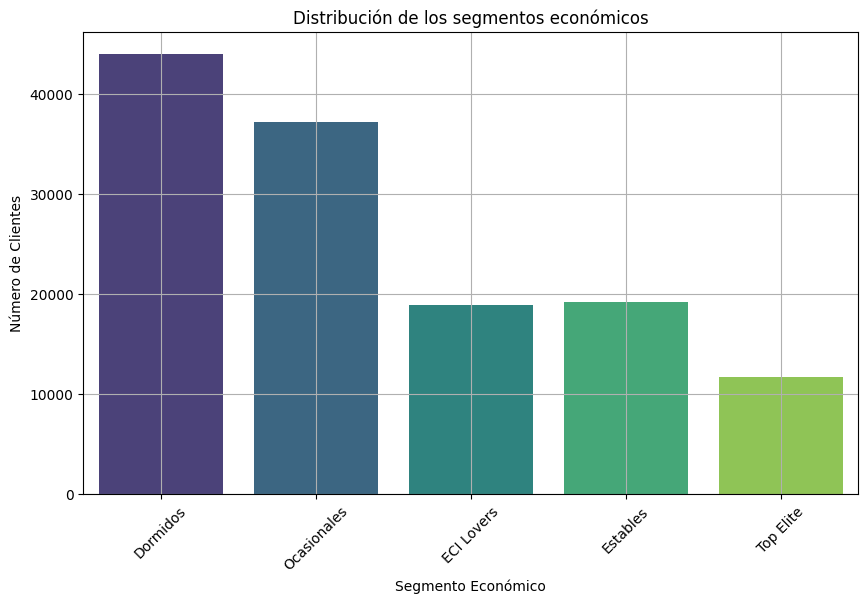

In [35]:
#Vamos a ver la distribución de los segmentos económicos
plt.figure(figsize=(10, 6))
sns.countplot(data=cliente_df, x='Cluster_Economico', palette='viridis')
plt.title('Distribución de los segmentos económicos')
plt.xlabel('Segmento Económico')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

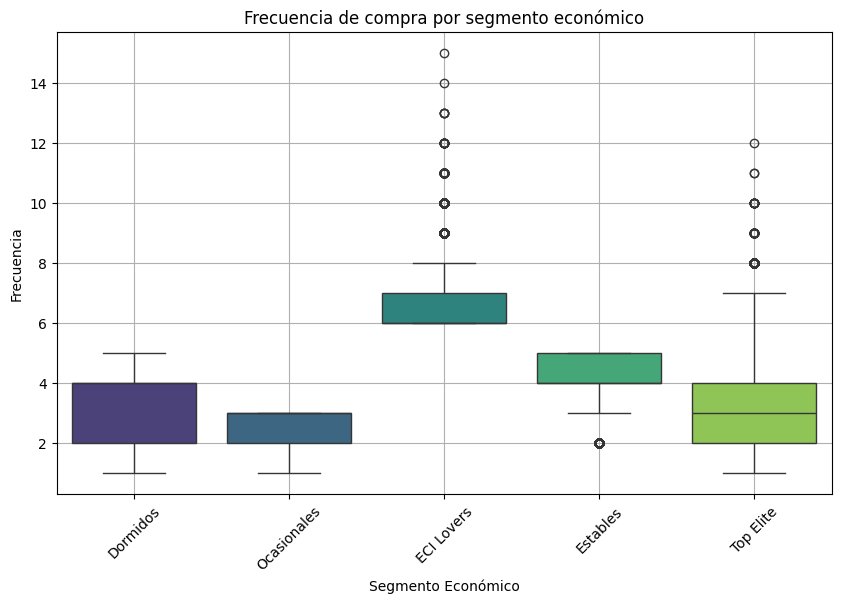

In [36]:
#Vamos a mostrar las estadisticas de la columnna Frecuencia segun el segmento economico
plt.figure(figsize=(10, 6))
sns.boxplot(data=cliente_df, x='Cluster_Economico', y='Frecuencia', palette='viridis')
plt.title('Frecuencia de compra por segmento económico')
plt.xlabel('Segmento Económico')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [37]:
cluster_summary = cliente_df.groupby('Cluster_Economico')[['Importe_total', 'Frecuencia', 'Dias_desde_ultima_factura']].mean().round(2)
print(cluster_summary)


                   Importe_total  Frecuencia  Dias_desde_ultima_factura
Cluster_Economico                                                      
Dormidos                  284.13        3.46                     551.18
ECI Lovers                622.25        6.66                     206.71
Estables                  374.02        4.27                      85.16
Ocasionales               258.80        2.60                     504.90
Top Elite                1148.86        3.61                     411.52



---

## 4. Vamos a ver una agrupación de segmentos por departamentos para visualizar en que departamentos suelen comprar

Categoria_top      Electrónica  Juguetería     Libros       Moda  Perfumería  \
Cluster_Economico                                                              
Dormidos             10.687679   34.979367  38.678323  24.231429   35.396068   
ECI Lovers            1.604585    7.888583   9.616090  15.177341   11.538909   
Estables              6.303725   14.552957  14.641154  12.561528   12.364778   
Ocasionales          15.530086   36.361761  33.255899  35.982899   35.663604   
Top Elite            65.873926    6.217331   3.808534  12.046803    5.036641   

Categoria_top      Souvenirs  Supermercado  Zapatería  
Cluster_Economico                                      
Dormidos           51.814798     37.777634  41.086846  
ECI Lovers         10.702652     19.752687   9.700356  
Estables           14.006515     17.458368  14.677501  
Ocasionales        19.474174     18.865120  27.221940  
Top Elite           4.001861      6.146190   7.313357  


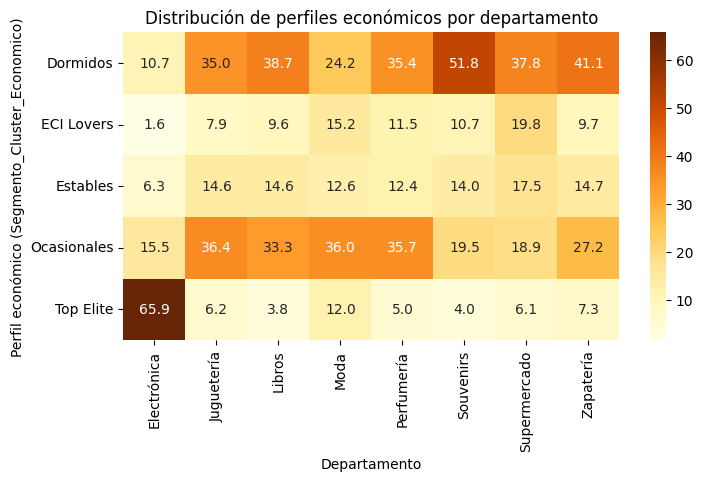

In [38]:
#departamentos_objetivo = ['Electrónica', 'Supermercado']
departamentos_objetivo = cliente_df['Categoria_top'].unique()
df_filtro = cliente_df[cliente_df['Categoria_top'].isin(departamentos_objetivo)]

tabla = pd.crosstab(df_filtro['Cluster_Economico'], df_filtro['Categoria_top'], normalize='columns') * 100
print(tabla)

plt.figure(figsize=(8, 4))
sns.heatmap(tabla, annot=True, fmt=".1f", cmap="YlOrBr")
plt.title("Distribución de perfiles económicos por departamento")
plt.ylabel("Perfil económico (Segmento_Cluster_Economico)")
plt.xlabel("Departamento")
plt.show()




#### Si observamos el mapa de calor, podríamos concluir lo siguiente:

- **Top Elite**: Este segmento de clientes, con un alto importe total y un alto ticket medio, concentra gran parte de su consumo en el departamento de **Electrónica**. Esto sugiere dos posibles estrategias:
  - Reforzar su comportamiento actual incentivando aún más la compra en ese departamento.
  - O bien, si se desea diversificar su consumo, lanzar campañas dirigidas a promover otros departamentos.

- **Dormidos**: Presentan un consumo distribuido en varios departamentos. Esto permite aplicar **estrategias variadas**, explorando distintos tipos de productos o campañas multidepartamento.

- **Ocasionales y Estables**: Ambos segmentos muestran patrones de consumo **balanceados**. Son adecuados para campañas de temporada como **rebajas**, promociones generalistas o eventos como "Black Friday".

- **ECI Lovers**: También presentan una distribución relativamente equilibrada, aunque con algo más de peso en departamentos como **Supermercado** y **Moda**. Pueden responder bien a **programas de fidelización** o **campañas de frecuencia de compra**.
